In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/tb3000/TUBERCULOSIS/TB (2900).png
/kaggle/input/tb3000/TUBERCULOSIS/TB (1186).png
/kaggle/input/tb3000/TUBERCULOSIS/TB (1935).png
/kaggle/input/tb3000/TUBERCULOSIS/TB (2562).png
/kaggle/input/tb3000/TUBERCULOSIS/TB (619).png
/kaggle/input/tb3000/TUBERCULOSIS/TB (1261).png
/kaggle/input/tb3000/TUBERCULOSIS/TB (2481).png
/kaggle/input/tb3000/TUBERCULOSIS/TB (2392).png
/kaggle/input/tb3000/TUBERCULOSIS/TB (324).png
/kaggle/input/tb3000/TUBERCULOSIS/TB (1384).png
/kaggle/input/tb3000/TUBERCULOSIS/TB (2103).png
/kaggle/input/tb3000/TUBERCULOSIS/TB (163).png
/kaggle/input/tb3000/TUBERCULOSIS/TB (646).png
/kaggle/input/tb3000/TUBERCULOSIS/TB (2621).png
/kaggle/input/tb3000/TUBERCULOSIS/TB (2295).png
/kaggle/input/tb3000/TUBERCULOSIS/TB (2055).png
/kaggle/input/tb3000/TUBERCULOSIS/TB (312).png
/kaggle/input/tb3000/TUBERCULOSIS/TB (1616).png
/kaggle/input/tb3000/TUBERCULOSIS/TB (2482).png
/kaggle/input/tb3000/TUBERCULOSIS/TB (492).png
/kaggle/input/tb3000/TUBERCULOSIS/TB (1195).pn

In [2]:
import re
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from kaggle_datasets import KaggleDatasets
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [3]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Device:', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()
print('Number of replicas:', strategy.num_replicas_in_sync)
    
print(tf.__version__)

Number of replicas: 1
2.4.1


In [4]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
GCS_PATH_1 =KaggleDatasets().get_gcs_path('tbx-11')
GCS_PATH_2 =KaggleDatasets().get_gcs_path('tuberculosis-tb-chest-xray-dataset') 
GCS_PATH_3 =KaggleDatasets().get_gcs_path('tb3000')
BATCH_SIZE = 30 * strategy.num_replicas_in_sync
IMAGE_SIZE = [180, 180]
EPOCHS = 35
print(BATCH_SIZE)

30


In [21]:
filenames= tf.io.gfile.glob(str(GCS_PATH_1 + '/TBX11K/imgs/tb/*'))
filenames_2= tf.io.gfile.glob(str(GCS_PATH_1 + '/TBX11K/imgs/health/*'))
filenames.extend(tf.io.gfile.glob(str(GCS_PATH_2 + '/TB_Chest_Radiography_Database/Normal/*')))
filenames.extend(tf.io.gfile.glob(str(GCS_PATH_2 + '/TB_Chest_Radiography_Database/Tuberculosis/*')))
filenames.extend(tf.io.gfile.glob(str(GCS_PATH_3 + '/TUBERCULOSIS/*')))

In [22]:
extra,add_normal=train_test_split(filenames_2,test_size=0.26)
filenames=filenames+add_normal

In [23]:
count_normal_tb(filenames)


	Total images count in training set : 8988

	Normal images count in training set : 4488
	Tuberculosis images count in training set : 4500

	The function classified the data correctly


(4488, 4500)

In [24]:
train_base,test_base=train_test_split(filenames,test_size=0.12)
train_1,val_1=train_test_split(train_base,test_size=0.2)

In [8]:
def count_normal_tb(file):
    print("\n\tTotal images count in training set : " + str(len(file)))
    COUNT_NORMAL = len([filename for filename in file if (("Normal" in filename) or ("health" in filename) or ("normal" in filename))])
    print("\n\tNormal images count in training set : " + str(COUNT_NORMAL))

    COUNT_TUBERCULOSIS = len([filename for filename in file if (("tb" in filename) or ("Tuberculosis" in filename) or ("TUBERCULOSIS" in filename) )])
    print("\tTuberculosis images count in training set : " + str(COUNT_TUBERCULOSIS))
    
    if (len(file)==(COUNT_NORMAL+COUNT_TUBERCULOSIS)):
        print("\n\tThe function classified the data correctly")
    else:
        print("\n\tThe function classification is wrong")
    return COUNT_NORMAL,COUNT_TUBERCULOSIS

In [25]:
print("\nTRAIN_1_DETAILS :")
COUNT_NORMAL,COUNT_TUBERCULOSIS=count_normal_tb(train_1)
print("\nVAL_1_DETAILS :")
count_normal_tb(val_1)

print("\nTEST_BASE_DETAILS :")
count_normal_tb(test_base)



TRAIN_1_DETAILS :

	Total images count in training set : 6327

	Normal images count in training set : 3142
	Tuberculosis images count in training set : 3185

	The function classified the data correctly

VAL_1_DETAILS :

	Total images count in training set : 1582

	Normal images count in training set : 811
	Tuberculosis images count in training set : 771

	The function classified the data correctly

TEST_BASE_DETAILS :

	Total images count in training set : 1079

	Normal images count in training set : 535
	Tuberculosis images count in training set : 544

	The function classified the data correctly


(535, 544)

In [26]:
def file_info(file):
    list_ds = tf.data.Dataset.from_tensor_slices(file)
    IMG_COUNT = tf.data.experimental.cardinality(list_ds).numpy()
    print("Images count: " + str(IMG_COUNT),"\n")
    
    return list_ds,IMG_COUNT
    

In [27]:
train_list_ds,TRAIN_IMG_COUNT= file_info(train_1)
val_list_ds,VAL_IMG_COUNT=file_info(val_1)
test_list_ds,TEST_IMG_COUNT=file_info(test_base)

for f in train_list_ds.take(5):
    print(f.numpy())

Images count: 6327 

Images count: 1582 

Images count: 1079 

b'gs://kds-13f2ccf7851aa7a99ded7d25ea726653f61fbbbba40e331638aa2739/TBX11K/imgs/health/h4369.png'
b'gs://kds-04eef8a1e7b710bdb0908f8150e790b75a2dd0b4987386c0ac02ffc2/TB_Chest_Radiography_Database/Normal/Normal-1779.png'
b'gs://kds-04eef8a1e7b710bdb0908f8150e790b75a2dd0b4987386c0ac02ffc2/TB_Chest_Radiography_Database/Normal/Normal-1847.png'
b'gs://kds-04eef8a1e7b710bdb0908f8150e790b75a2dd0b4987386c0ac02ffc2/TB_Chest_Radiography_Database/Tuberculosis/Tuberculosis-332.png'
b'gs://kds-1d061b4b5171fc2532ee3f41e78015bfaa4245afa3a0be27f92650fe/TUBERCULOSIS/TB (2172).png'


In [28]:
def get_label(file_path):

    parts = tf.strings.split(file_path, os.path.sep)
    if ((parts[-2]== "Tuberculosis") or (parts[-2]=="tb") or (parts[-2]== "TUBERCULOSIS")) :
        return True
    elif ((parts[-2]== "Normal") or (parts[-2]=="health") or (parts[-2]=="normal")):
        return False
    else:
        return False

In [29]:
def decode_img(img):
    img=tf.image.decode_image(img, channels=3,expand_animations=False)
    img=tf.image.convert_image_dtype(img,tf.float32)
    return tf.image.resize(img, IMAGE_SIZE)

In [30]:
def process_path(file_path):
    label = get_label(file_path)
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    return img, label

In [31]:
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [32]:
def prepare_for_Data_Aug(ds, cache=False,repeat=False,shuffle=False, shuffle_buffer_size=1000):

    if cache: # only for training and validation data set
        if isinstance(cache, str):
            ds = ds.cache(cache)
        else:
            ds = ds.cache()
            
    if shuffle: # only for training and validation data set
        ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    
    normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)
    ds = ds.map(lambda x, y: (normalization_layer(x), y))
    
    if repeat: # only for training and validation data set
        ds = ds.repeat()

    ds = ds.batch(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)


    return ds

In [33]:
train_ds = prepare_for_Data_Aug(train_ds,cache=True,repeat=True,shuffle=True,shuffle_buffer_size=(TRAIN_IMG_COUNT//4))

val_ds = prepare_for_Data_Aug(val_ds,cache=True,repeat=True,shuffle=True,shuffle_buffer_size=(VAL_IMG_COUNT//4))

test_ds= prepare_for_Data_Aug(test_ds)

In [34]:
def conv_block(filters):
    
    block = tf.keras.Sequential([
        
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
        
    ])
    
    return block

In [35]:
def dense_block(units, dropout_rate):
    
    block = tf.keras.Sequential([
        
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
        
    ])
    
    return block

In [36]:
def data_aug():
    
    block = tf.keras.Sequential([

            tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal",),
            tf.keras.layers.experimental.preprocessing.RandomFlip("vertical",),

    ])
    
    return block

In [37]:
def build_model():
    model = tf.keras.Sequential([
        
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        data_aug(),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
        
    ])
    
    return model

In [38]:
with strategy.scope():
    
    model = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer=keras.optimizers.Adam(),
        loss=keras.losses.BinaryCrossentropy(from_logits=True),
        metrics=METRICS
    )

In [39]:
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("xray_model.h5",
                                                    save_best_only=True)

early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=10,
                                                     restore_best_weights=True)

def exponential_decay(lr0, s):
    def exponential_decay_fn(epoch):
        return lr0 * 0.1 **(epoch / s)
    return exponential_decay_fn

exponential_decay_fn = exponential_decay(0.01, 20)

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(exponential_decay_fn)

In [40]:
hist = model.fit(
    train_ds,
    steps_per_epoch=int(np.ceil(TRAIN_IMG_COUNT // float(BATCH_SIZE))),
    epochs=EPOCHS,
    validation_data=val_ds,
    validation_steps=int(np.ceil(VAL_IMG_COUNT // float(BATCH_SIZE))),
    callbacks=[checkpoint_cb, early_stopping_cb, lr_scheduler]
)

Epoch 1/35
210/210 [==============================] - 934s 4s/step - loss: 0.6889 - accuracy: 0.6507 - precision: 0.6572 - recall: 0.6274 - val_loss: 4.2109 - val_accuracy: 0.4859 - val_precision: 0.4859 - val_recall: 1.0000
Epoch 2/35
210/210 [==============================] - 21s 98ms/step - loss: 0.3480 - accuracy: 0.8534 - precision: 0.8577 - recall: 0.8524 - val_loss: 1.6614 - val_accuracy: 0.5321 - val_precision: 0.5114 - val_recall: 0.9725
Epoch 3/35
210/210 [==============================] - 21s 98ms/step - loss: 0.3007 - accuracy: 0.8776 - precision: 0.8891 - recall: 0.8625 - val_loss: 2.9983 - val_accuracy: 0.4147 - val_precision: 0.4469 - val_recall: 0.8144
Epoch 4/35
210/210 [==============================] - 20s 97ms/step - loss: 0.2750 - accuracy: 0.8819 - precision: 0.8854 - recall: 0.8755 - val_loss: 3.3839 - val_accuracy: 0.4910 - val_precision: 0.4900 - val_recall: 1.0000
Epoch 5/35
210/210 [==============================] - 21s 98ms/step - loss: 0.2754 - accuracy: 0.

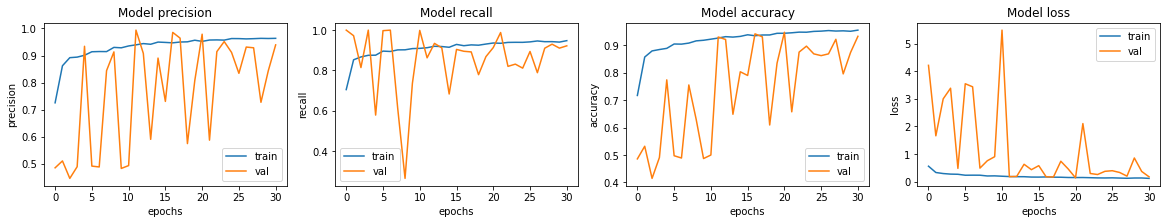

In [42]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(hist.history[met])
    ax[i].plot(hist.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [44]:
model.evaluate(test_ds)

36/36 [==============================] - 120s 3s/step - loss: 0.1499 - accuracy: 0.9453 - precision: 0.9764 - recall: 0.9136


[0.14986583590507507,
 0.9453197121620178,
 0.9764243364334106,
 0.9136029481887817]

In [45]:
model.save('./Tuberculosis_tf',save_format='tf')

In [46]:
model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 180, 180, 16)      448       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 180, 180, 16)      2320      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 90, 90, 16)        0         
_________________________________________________________________
sequential_1 (Sequential)    (None, 45, 45, 32)        2160      
_________________________________________________________________
sequential_2 (Sequential)    (None, 22, 22, 64)        7392      
_________________________________________________________________
sequential_3 (Sequential)    (None, 11, 11, 128)      

In [47]:
!zip -r Tuberculosis.zip {'./Tuberculosis_tf'}

  adding: Tuberculosis_tf/ (stored 0%)
  adding: Tuberculosis_tf/saved_model.pb (deflated 90%)
  adding: Tuberculosis_tf/assets/ (stored 0%)
  adding: Tuberculosis_tf/variables/ (stored 0%)
  adding: Tuberculosis_tf/variables/variables.index (deflated 75%)
  adding: Tuberculosis_tf/variables/variables.data-00000-of-00001 (deflated 7%)


In [ ]:
model_2.evaluate(test_ds_2)